## Libraries

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

## Load network and node attributes

Number of nodes: 1500
Number of edges: 6600


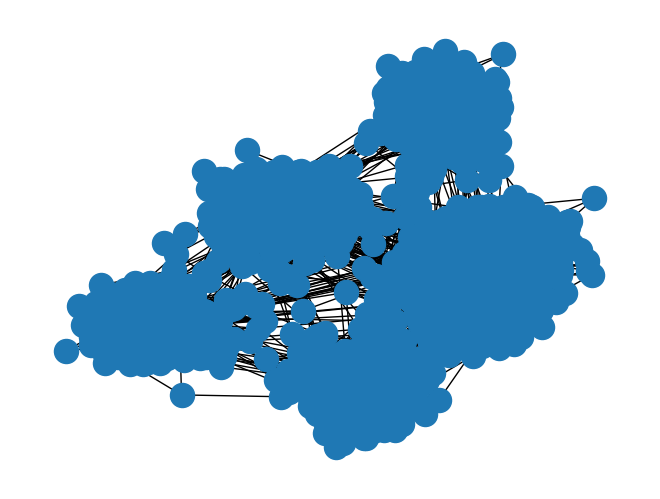

In [32]:
# Load network
G = nx.read_edgelist('edges_train.edgelist', delimiter=',', nodetype=int)

# Load node attributes
attributes = pd.read_csv('attributes.csv', header=None, names=['attribute'])

# Build mapping: node_id -> attribute_value
attr_map = dict(enumerate(attributes['attribute'].values))

nx.set_node_attributes(G, attr_map, name='attribute')

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

pos = nx.spring_layout(G)
nx.draw(G, pos=pos)

## Feature engineering

In [33]:
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index
from networkx.algorithms.community import greedy_modularity_communities
comms = list(greedy_modularity_communities(G))

def extract_features(G, u, v):
    
    # mutual friends
    common_neighbors = len(list(nx.common_neighbors(G, u, v))) 
    
    # how "social" is u
    degree_u = G.degree(u) # how "social" is u
    
    # how "social" is v
    degree_v = G.degree(v) 

    # Same attribute
    attr_u = G.nodes[u]['attribute']
    attr_v = G.nodes[v]['attribute']
    same_attr = int(attr_u == attr_v) # 1 for true, 0 for false

    # Jaccard coefficient: Measures the fraction of mutual friends out of all possible friends of u and v
    jaccard = next(jaccard_coefficient(G, [(u, v)]))[2]

    # Adamic-Adar index: Weights 'rare' mutual friends more between u and v
    adamic_adar = next(adamic_adar_index(G, [(u, v)]))[2]

    # same community
    same_comm = int(any(u in c and v in c for c in comms))

    return [common_neighbors, degree_u, degree_v, same_attr, jaccard, adamic_adar, same_comm]


## Get positive and negative examples

In [34]:
# Positive examples (existing edges)
positive_edges = list(G.edges())
y_pos = np.ones(len(positive_edges))

# Negative examples (non-existent edges)
non_edges = list(nx.non_edges(G))
np.random.shuffle(non_edges)
negative_edges = non_edges[:len(positive_edges)] # equal number of negative samples to balance dataset
y_neg = np.zeros(len(negative_edges))

# Combine
edges = positive_edges + negative_edges
y = np.concatenate([y_pos, y_neg])

# Compute features
X = np.array([extract_features(G, u, v) for u, v in edges])


## Train and test split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y # use stratify to preserve class balance
)

## Train supervised model and perform cross validation

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

model = LogisticRegression(max_iter=1000, solver="liblinear")  # simple logistic regression

# Perform 5-fold cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
print("Cross-val accuracy: %.3f ± %.3f" % (cv_scores.mean(), cv_scores.std()))

# Train on the full training set
model.fit(X_train, y_train)

# Evaluate on the unseen test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC-AUC :", roc_auc_score(y_test, y_prob))

Cross-val accuracy: 0.888 ± 0.006
Test Accuracy: 0.8861111111111111
Test ROC-AUC : 0.9391576114682175


## Make predictions using solutionInput.csv and generate output for Kaggle competition

In [37]:
test_pairs = pd.read_csv('solutionInput.csv')

# Extract features for test pairs
X_final = np.array([extract_features(G, int(u), int(v)) 
                    for u, v in zip(test_pairs['int1'], test_pairs['int2'])])

preds = model.predict(X_final)

# Save output for kaggle
output = pd.DataFrame({
    'ID': test_pairs.index,
    'Predicted': preds.astype(int)
})
output.to_csv('solutionOutput2.csv', index=False)

print("saved output solution")


saved output solution
